In [1]:
# best 3 solutions based on EXP1 in turns of f1 weighted is:
# XGBcls, RoadNet+Segment TOTAL, 0.5284741533025521
# XGBreg, RoadNet+Segment NO_TOTAL, 0.541270
# GDBcls, RoadNet+Segment TOTAL
# with ~2014, min-max, no feature selection

In [2]:
from wKit.utility.check_dtype import all_float
from wKit.utility.ipynb_helper import multi_column_df_display
from wKit.ML.sk_ml import confusion_matrix_as_df, show_important_features

In [3]:
from collections import defaultdict

In [4]:
import pandas as pd
import xgboost
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sklearn.metrics import f1_score

In [6]:
def load_data():
    y = pd.read_csv('data/y_csl_all.csv', index_col=0).csl
    X_total = pd.read_csv('data/x_TOTAL_~2014.csv', index_col=0)
    X_type = pd.read_csv('data/x_NO_TOTAL_~2014.csv', index_col=0)
    Xs = {'NO_TOTAL': X_type, 'TOTAL': X_total}
    return Xs, y

In [7]:
def train_test_idx(seed):
    idx_fn = 'data/csl_experiment/seed_%d/indices.txt' % seed
    with open(idx_fn) as f:
        lines = f.readlines()
        train_idx = lines[0].strip().split('\t')[1].split(',')
        train_idx = [int(x) for x in train_idx]
        test_idx = lines[1].strip().split('\t')[1].split(',')
        test_idx = [int(x) for x in test_idx]
    return train_idx, test_idx

In [26]:

from wKit.ML.scaler import minmax
def scale_ftr(train_x, test_x):
    scaler = minmax()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    return train_x, test_x

In [8]:
def init_model(name):
    if name == 'XGBreg': model = xgboost.XGBRegressor()
    elif name == 'XGBcls': model = xgboost.XGBClassifier()
    elif name == 'GDBcls': model = GradientBoostingClassifier()
    else: raise('no model')
    return model

In [9]:
def load_params(seed, total_or_not, name):
    cv_res_fn = 'data/csl_experiment/seed_%d/RoadNet+Segment#%s#~2014#min-max#None/cv_5_model_%s.csv' % (seed, total_or_not, name)
    return eval(pd.read_csv(cv_res_fn,index_col=0)['params'].values[0])
    

In [53]:
seeds = [0, 100, 972, 5258, 7821, 40918, 57852, 168352, 291592, 789729423]
combo = [('TOTAL', 'XGBcls'), ('NO_TOTAL', 'XGBreg'), ('TOTAL', 'GDBcls')]

In [11]:
Xs, y = load_data()


In [89]:
imps = defaultdict(list)
cfsn_norms = defaultdict(list)
cfsns = defaultdict(list)
f1s = defaultdict(list)

for seed in seeds:
    train_idx, test_idx = train_test_idx(seed)
    train_y, test_y = y.loc[train_idx], y.loc[test_idx]
    print('======', seed, len(test_y))
    for total_or_not, name in combo:
#         print(total_or_not, name)
        X = Xs[total_or_not]
        train_x, test_x = X.loc[train_idx], X.loc[test_idx]
        feature_names = train_x.columns
        train_x, test_x = scale_ftr(train_x, test_x)
        params = load_params(seed, total_or_not, name)
        model = init_model(name)
        model.set_params(**params)
        if 'reg' in name: 
            model.fit(train_x, train_y)
        else:
            model.fit(train_x, train_y.round())
        
#         f1s[name].append(f1_score(test_y.round(), model.predict(test_x).round(), average='weighted'))
        
        imp = show_important_features(model, labels=feature_names, set_std=False, show_plt=False).drop('std', axis=1) 
        imp.columns = ['label', 'importance_%d' % seed]
        cfsn_norm = confusion_matrix_as_df(model, test_x, test_y, labels=[1, 2, 3, 4, 5], normalize=True)
        cfsn = confusion_matrix_as_df(model, test_x, test_y, labels=[1, 2, 3, 4, 5])
        
        imps[name].append(imp)
        cfsn_norms[name].append(cfsn_norm)
        cfsns[name].append(cfsn)

====== 0 63
====== 100 63
====== 972 63
====== 5258 63
====== 7821 63
====== 40918 63
====== 57852 63
====== 168352 63
====== 291592 63
====== 789729423 63


In [30]:
# sum(f1s['XGBcls'])/10, sum(f1s['XGBreg'])/10, sum(f1s['GDBcls'])/10, 

(0.5317529360068185, 0.50706339844391946, 0.49762484714346683)

# confusion matrix

In [101]:
for total_or_not, name in combo:
    total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
    cfsn_norm = sum(cfsn_norms[name])/len(seeds)
    cfsn_norm.to_csv('deliverables/EXP2-average_confusion_matrix_in_pcnt_%s_%s.csv' % (name, total_or_type))
    cfsn = sum(cfsns[name])/len(seeds)
    cfsn.to_csv('deliverables/EXP2-average_confusion_matrix_%s_%s.csv' % (name, total_or_type))
    cfsn_pcnt_per_row = cfsn.apply(lambda x: x / x.sum(), axis=1)
    cfsn_pcnt_per_row.to_csv('deliverables/EXP2-average_confusion_matrix_as_pcnt_per_row_%s_%s.csv' % (name, total_or_type))
    

In [20]:
import numpy as np

In [59]:
def cal_neighbor_miss_pcnt(cfsn):
    non_dia = pd.DataFrame(np.where(np.eye(np.min(cfsn.shape)), np.nan, cfsn.values), cfsn.index, cfsn.columns)
    sum_missed_classified = non_dia.sum().sum()

    sum_next_class = 0
    sum_prev_class = 0
    for i in range(cfsn.shape[0]):
        print(i, end=' ')
        if i>0:
            prev_class = cfsn.iloc[i, i-1]
            sum_prev_class+=prev_class
            print('prev', prev_class,end=' ')
        if i+1<cfsn.shape[0]:
            next_class = cfsn.iloc[i, i+1]
            sum_next_class+=next_class
            print('next', next_class,end=' ')
        print()
    print(sum_prev_class, sum_next_class)
    print('more_dangerous', sum_prev_class/sum_missed_classified, '\n',
          'safer', sum_next_class/sum_missed_classified, '\n',
          'neighbour_class', (sum_prev_class+sum_next_class)/sum_missed_classified)

In [60]:
from IPython.display import display

In [61]:
for total_or_not, name in combo:
    print(name)
    total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
    cfsn = pd.read_csv('deliverables/EXP2 average_confusion_matrix_%s_%s.csv' % (name, total_or_type), index_col=[0,1], header=[0,1])
    display(cfsn)
    cal_neighbor_miss_pcnt(cfsn)

XGBcls


pred                      
          1    2     3     4    5
True 1  0.1  1.0   0.8   0.0  0.0
     2  0.4  3.6   6.3   0.9  0.0
     3  0.8  3.0  17.2   5.2  0.0
     4  0.2  0.5   7.2  13.4  0.1
     5  0.0  0.1   1.0   1.0  0.2

0 next 1.0 
1 prev 0.4 next 6.3 
2 prev 3.0 next 5.2 
3 prev 7.2 next 0.1 
4 prev 1.0 
11.6 12.6
more_dangerous 0.40701754386 
 safer 0.442105263158 
 neighbour_class 0.849122807018
XGBreg


pred                      
          1    2     3     4    5
True 1  0.0  1.4   0.5   0.0  0.0
     2  0.1  2.9   7.7   0.5  0.0
     3  0.1  2.4  20.2   3.5  0.0
     4  0.0  0.6   9.9  10.9  0.0
     5  0.0  0.0   0.9   1.4  0.0

0 next 1.4 
1 prev 0.1 next 7.7 
2 prev 2.4 next 3.5 
3 prev 9.9 next 0.0 
4 prev 1.4 
13.8 12.6
more_dangerous 0.475862068966 
 safer 0.434482758621 
 neighbour_class 0.910344827586
GDBcls


pred                      
          1    2     3     4    5
True 1  0.1  1.0   0.8   0.0  0.0
     2  0.5  2.2   7.5   1.0  0.0
     3  0.5  2.5  19.0   4.2  0.0
     4  0.1  0.4   7.6  13.1  0.2
     5  0.0  0.0   1.0   1.3  0.0

0 next 1.0 
1 prev 0.5 next 7.5 
2 prev 2.5 next 4.2 
3 prev 7.6 next 0.2 
4 prev 1.3 
11.9 12.9
more_dangerous 0.416083916084 
 safer 0.451048951049 
 neighbour_class 0.867132867133


0 next 1.0 
1 prev 0.4 next 6.3 
2 prev 3.0 next 5.2 
3 prev 7.2 next 0.1 
4 prev 1.0 
11.6 12.6
0.40701754386 0.442105263158 0.849122807018


28.500000000000004

In [81]:
def plot_imp(list_imp, name, total_or_type, top=10):
    imp = pd.DataFrame(columns=['label'])
    for df in list_imp:
        imp = imp.merge(df, on='label', how='outer')

    imp = imp.set_index('label')
    means = imp.mean(axis=1)
    stds = imp.std(axis=1)
    means_to_plot = means.sort_values(ascending=False).head(top)
    index_to_plot = means_to_plot.index
    stds_to_plot = stds.loc[index_to_plot]
    ax = means_to_plot.sort_values().plot(kind='barh', xerr=stds_to_plot, figsize=(10,7))
    ax.set_xlabel('importance with std as errorbar')
    ax.set_ylabel('feature')
    fig = ax.get_figure()
    fig.savefig(u'deliverables/EXP2-feature importance - %s_RoadNet+social_%s.png' % (name, total_or_type), format='png', bbox_inches='tight', pad_inches=0)
    

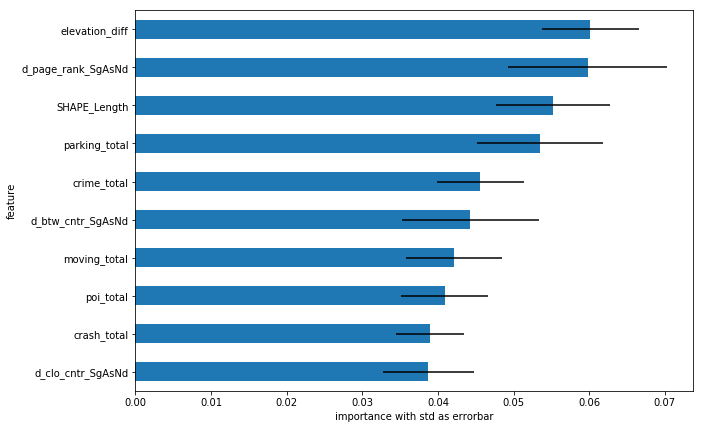

In [85]:
total_or_not, name = combo[0]
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
plot_imp(imps[name], name, total_or_type, 10)

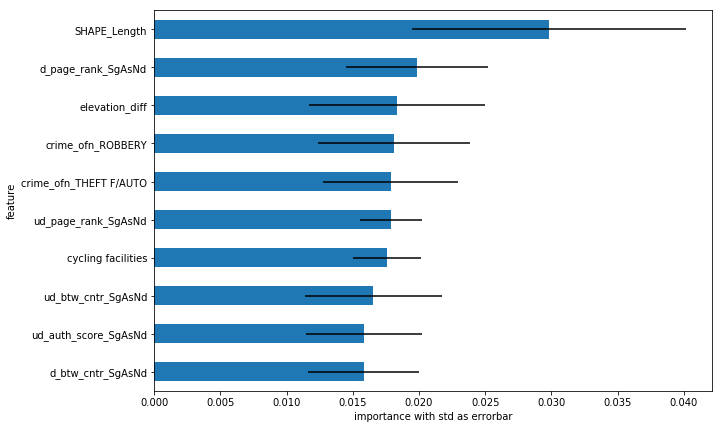

In [87]:
total_or_not, name = combo[1]
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
plot_imp(imps[name], name, total_or_type, 10)

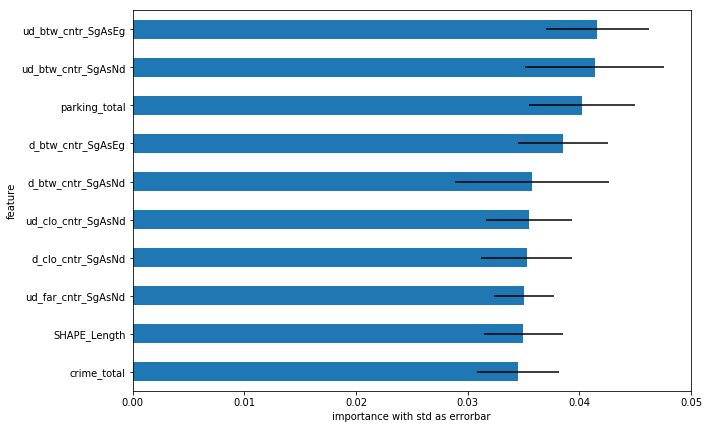

In [86]:
total_or_not, name = combo[2]
total_or_type = {'TOTAL': 'total', 'NO_TOTAL': 'type'}[total_or_not]
plot_imp(imps[name], name, total_or_type, 10)